# University of Exeter
## College of Engineering, Mathematics and Physical  Sciences
### ECM3420 - Learning From Data

#### Coursework 2 - Clustering

### Candidate number: 670021141

## Task 1

In [1]:
import numpy as np
import random


In [2]:
"""

Choose k unique initial centroids from x.

"""
def initialise_centroids(x, k, random_state=None):
    centroids = []

    # Choose k random unique points for initial centroids
    if random_state:
        random.seed(random_state)

    return random.sample(list(x),k)


In [3]:
"""

Calculate Euclidean distance between point_1 and point_2.

"""
def euclidian_distance(point_1, point_2):
    # return np.sqrt(sum([np.square(point_1[x] - point_2[x]) for x in range(length)]))
    return sum((p1 - p2) ** 2 for p1, p2 in zip(point_1, point_2)) ** 0.5



In [4]:
"""

Find the closest centroid to a given point.

"""
def choose_best_cluster(point, centroids):
    distances = {}
    
    # Construct index to distance mapping
    key = 0
    for centroid in centroids:
        distances[key] = euclidian_distance(point, centroid)
        key += 1
    
    # Return index with shortest distnace
    return min(distances, key=distances.get)


In [5]:
"""

Return the cluster index that a given point belongs to.

"""
def obtain_cluster(point, clusters):
    # Unpack the dictionary
    for key, points in clusters.items():
        # Check if the point belongs to the cluster
        for p in points:
            if np.array_equal(p, point):
                return key


In [6]:
"""

Update a centroid (specified by key) in the centroid list (centroids), based on its corresponding points in
the clusters dictionary.

"""
def update_centroid(key, centroids, clusters):
    centroids[key] = np.mean(clusters[key], axis=0)


In [7]:
"""

Incremental KMeans Algorithm.

""" 
def incremental_kmeans(x, k, max_itr=100, random_state=None):
    full_iterations = 1
    clusters = {}
    cluster_labels = []
    centroid_updated = True

    # Choose random centroids, initialise clusters
    centroids = initialise_centroids(x, k, random_state)
    
    # For each data point, find nearest cluster and update centroid
    for point in x:
        
        # Find nearest cluster
        best_cluster_key = choose_best_cluster(point, centroids)
        
        # Update nearest cluster
        if best_cluster_key not in clusters:
            clusters.update({best_cluster_key:[point]})
        else:
            clusters[best_cluster_key].append(point)
            
        update_centroid(best_cluster_key, centroids, clusters)
        
        # Update output
        cluster_labels.append(best_cluster_key)
    
    full_iterations += 1

    
    # Remaining iterations
    while centroid_updated and full_iterations < max_itr:
        
        centroid_updated = False
        original_centroids = centroids.copy()
        
        index = 0
        for point in x:
            # Obtain current cluster
            current_cluster_key = obtain_cluster(point, clusters)

            # Calculate nearest cluster
            best_cluster_key = choose_best_cluster(point, centroids)

            # If the clusters are different, re-assign
            if current_cluster_key != best_cluster_key:
                
                # Remove from current cluster and update its centroid
                i = 0
                size = len(clusters[current_cluster_key])
                while i < size:
                    if np.array_equal(clusters[current_cluster_key][i], point):
                        del clusters[current_cluster_key][i]
                        break
                    i += 1
                update_centroid(current_cluster_key, centroids, clusters)

                # Add to new cluster and update its centroid
                clusters[best_cluster_key].append(point)
                update_centroid(best_cluster_key, centroids,  clusters)

                # Update output
                cluster_labels[index] = best_cluster_key
            
            index += 1

        # Update stopping condition
        if not np.array_equal(original_centroids, centroids):
            centroid_updated = True

        full_iterations += 1
        
    
    cluster_labels = np.array(cluster_labels)
    
    return cluster_labels, full_iterations


## Task 2

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [9]:
"""

Perform runtime analysis. 
Returns a Dataframe for each KMeans Algorithm, and data for the Incremental KMeans boxplot (runtime distributions).

"""

def runtime_analysis(data, k_values, m):
    
    # Preprocessing
    sc = StandardScaler()
    sc.fit(data)
    data = sc.transform(data)
    
    # Prepare dataframes and boxplot data
    kmeans_df = pd.DataFrame(columns=['Standard KMeans','K=2','K=3','K=4','K=5'], index=['Average Time','Average Iterations'])
    kmeans_incr_df = pd.DataFrame(columns=['Incremental KMeans','K=2','K=3','K=4','K=5'], index=['Average Time','Average Iterations'])
    boxplot_data = []
    
    # Perform experiment and store results...
    random_state = 0
    kmeans_avg_times = []
    kmeans_avg_iters = []
    kmeans_incr_avg_times = []
    kmeans_incr_avg_iters = []
    
    for k in k_values:
        
        kmeans_time = []
        kmeans_iter = []
        kmeans_incr_time = []
        kmeans_incr_iter = []
        
        for m in range(m):
            # Standard KMeans
            kmeans = KMeans(n_clusters = k, random_state = random_state)
            start_time = time.time()
            kmeans.fit(data)
            end_time_milliseconds = (time.time() - start_time) * 1000
            kmeans_time.append(end_time_milliseconds)
            kmeans_iter.append(kmeans.n_iter_)
            
            # Incremental KMeans
            start_time = time.time()
            cluster_labels, full_iterations = incremental_kmeans(data, k, random_state = random_state)
            end_time_milliseconds = (time.time() - start_time) * 1000
            kmeans_incr_time.append(end_time_milliseconds)
            kmeans_incr_iter.append(full_iterations)
            
            # Change state for next iteration
            random_state += 1
       
        # Store results
        kmeans_avg_times.append(np.mean(kmeans_time))
        kmeans_avg_iters.append(np.mean(kmeans_iter))
        kmeans_incr_avg_times.append(np.mean(kmeans_incr_time))
        kmeans_incr_avg_iters.append(np.mean(kmeans_incr_iter))
        boxplot_data.append(kmeans_incr_time)
        
    
    # Populate dataframes with results
    kmeans_df.loc['Average Time'] = pd.Series({'Standard KMeans':'Average Time', 'K=2':kmeans_avg_times[0], 'K=3':kmeans_avg_times[1], 'K=4':kmeans_avg_times[2], 'K=5':kmeans_avg_times[3]})
    kmeans_df.loc['Average Iterations'] = pd.Series({'Standard KMeans':'Average Iterations', 'K=2':kmeans_avg_iters[0], 'K=3':kmeans_avg_iters[1], 'K=4':kmeans_avg_iters[2], 'K=5':kmeans_avg_iters[3]})
    kmeans_incr_df.loc['Average Time'] = pd.Series({'Incremental KMeans':'Average Time', 'K=2':kmeans_incr_avg_times[0], 'K=3':kmeans_incr_avg_times[1], 'K=4':kmeans_incr_avg_times[2], 'K=5':kmeans_incr_avg_times[3]})
    kmeans_incr_df.loc['Average Iterations'] = pd.Series({'Incremental KMeans':'Average Iterations', 'K=2':kmeans_incr_avg_iters[0], 'K=3':kmeans_incr_avg_iters[1], 'K=4':kmeans_incr_avg_iters[2], 'K=5':kmeans_incr_avg_iters[3]})
    
    return kmeans_df, kmeans_incr_df, boxplot_data


In [10]:
"""
Runtime Analysis
"""

x = load_iris().data
k_values = [2, 3, 4, 5]
m = 5

# Obtain the data
kmeans_df, kmeans_incr_df, boxplot_data = runtime_analysis(x, k_values, m)


In [11]:
# Show the results for Standard KMeans
kmeans_df.style.hide_index()


Standard KMeans,K=2,K=3,K=4,K=5
Average Time,23.730183,27.924359,33.702691,36.608696
Average Iterations,3.200000,6.000000,5.000000,7.500000


In [12]:
# Show the results for Incremental KMeans
kmeans_incr_df.style.hide_index()


Incremental KMeans,K=2,K=3,K=4,K=5
Average Time,73.004055,195.456028,141.962449,225.689292
Average Iterations,3.400000,5.750000,4.666667,6.000000


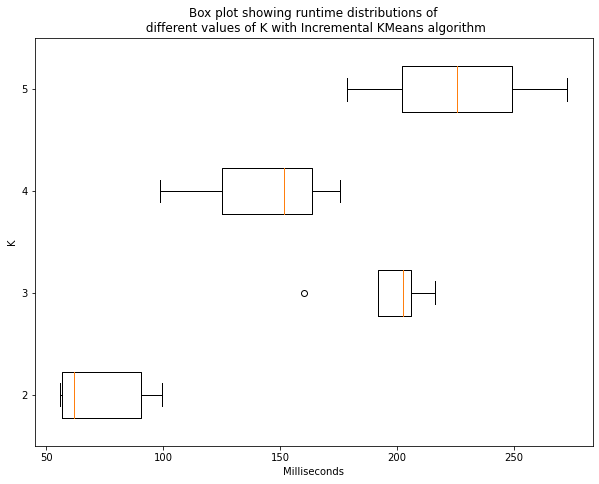

In [13]:
"""

Drawing chart to show the runtime distributions of the Incremental KMeans algorithm. 

"""

# Create figure and axes
fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(10)

# Build boxplot with the runtime distributions data
ax.boxplot(boxplot_data, showmeans=False, vert=False)

# Set title and axes labels
ax.set_title('Box plot showing runtime distributions of\n different values of K with Incremental KMeans algorithm')
ax.set_xlabel('Milliseconds')
ax.set_ylabel('K')

# Add y-tick labels
ax.set_yticks(range(1, len(k_values) + 1))
ax.set_yticklabels([str(k) for k in k_values])

# Show the plot
plt.show()


## Task 3

In [14]:
"""

Calculate the Jaccard Index as demonstrated in Week 8, Video 3.

"""
def jaccard_index_cw2(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise Error #TODO: handle this
    
    scores = [0, 0, 0]
     
    for i in range(len(y_true)):
        for j in range(i + 1, len(y_pred)):
            # SS
            if y_true[i] == y_true[j] and y_pred[i] == y_pred[j]:
                scores[0] += 1
            # SD
            elif y_true[i] == y_true[j] and y_pred[i] != y_pred[j]:
                scores[1] += 1
            # DS
            elif y_true[i] != y_true[j] and y_pred[i] == y_pred[j]:
                scores[2] += 1
    
    return scores[0] / sum(scores)
        

## Task 4

In [15]:
"""

Compare true output labels to predicted output labels, and return a 3x3 list of values for the Q4 Dataframe.

"""
def get_cluster_values_q4(y_true, y_pred):
    
    cluster_values = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

    for index in range(len(y_true)):
        
        cluster = y_pred[index]
        label = y_true[index]
        
        if cluster == 0:
            if label == 0:
                cluster_values[0][0] += 1
            elif label == 1:
                cluster_values[0][1] += 1
            elif label == 2:
                cluster_values[0][2] += 1
        
        if cluster == 1:
            if label == 0:
                cluster_values[1][0] += 1
            elif label == 1:
                cluster_values[1][1] += 1
            elif label == 2:
                cluster_values[1][2] += 1
        
        if cluster == 2:
            if label == 0:
                cluster_values[2][0] += 1
            elif label == 1:
                cluster_values[2][1] += 1
            elif label == 2:
                cluster_values[2][2] += 1
    
    return cluster_values


In [16]:
"""

Populate and return a Dataframe with the given title and 3x3 list of values.

"""
def get_dataframe_q4(title, values):
    
    data = {title:  ['Cluster 1', 'Cluster 2', 'Cluster 3'],
         'Label 1': [values[0][0], values[0][1], values[0][2]],
         'Label 2': [values[1][0], values[1][1], values[1][2]],
         'Label 3': [values[2][0], values[2][1], values[2][2]]
           }
    
    df = pd.DataFrame(data, columns = [title, 'Label 1', 'Label 2', 'Label 3'])

    return df


In [17]:
"""

KMeans Cluster Analysis.

"""

data = load_iris()
x = data.data
y_true = data.target

# Preprocessing
sc = StandardScaler()
sc.fit(x)
x = sc.transform(x)

# Standard KMeans
kmeans = KMeans(n_clusters = 3, random_state = 10)
kmeans.fit(x)
y_kmeans = kmeans.predict(x)

# Analysis
cluster_values_kmeans = get_cluster_values_q4(y_true, y_kmeans)
df_kmeans = get_dataframe_q4('Standard K-Means', cluster_values_kmeans)

# Show the results
df_kmeans.style.hide_index()


Standard K-Means,Label 1,Label 2,Label 3
Cluster 1,0,50,0
Cluster 2,39,0,11
Cluster 3,14,0,36


In [18]:
# Incremental KMeans
y_kmeans_incr, _ = incremental_kmeans(x, k = 3, random_state = 10)

# Analysis
cluster_values_kmeans_incr = get_cluster_values_q4(y_true, y_kmeans_incr)
df_kmeans_incr = get_dataframe_q4('Incremental K-Means', cluster_values_kmeans_incr)

# Show the results
df_kmeans_incr.style.hide_index()


Incremental K-Means,Label 1,Label 2,Label 3
Cluster 1,1,49,0
Cluster 2,37,0,13
Cluster 3,8,0,42


In [19]:
"""

Jaccard Index comparison.

"""

from sklearn.metrics import jaccard_score

# Calculate Jaccard Index (cw2, sklearn) for KMeans results (standard, incremental)
jaccard_kmeans_cw2          = jaccard_index_cw2(y_true, y_kmeans)
jaccard_kmeans_sklearn      = jaccard_score(y_true, y_kmeans, average = "micro")
jaccard_kmeans_incr_cw2     = jaccard_index_cw2(y_true, y_kmeans_incr)
jaccard_kmeans_incr_sklearn = jaccard_score(y_true, y_kmeans_incr, average = "micro")

# Build Dataframe for output
jaccard_data = {'Jaccard Index':  ['jaccard_index_cw2', 'sklearn.metrics.jaccard_score'],
                'Standard KMeans': [jaccard_kmeans_cw2, jaccard_kmeans_sklearn],
                'Incremental KMeans': [jaccard_kmeans_incr_cw2, jaccard_kmeans_incr_sklearn]
               }
df = pd.DataFrame(jaccard_data, columns = ['Jaccard Index', 'Standard KMeans', 'Incremental KMeans'])

# Show the results
df.style.hide_index()


Jaccard Index,Standard KMeans,Incremental KMeans
jaccard_index_cw2,0.593892,0.615739
sklearn.metrics.jaccard_score,0.136364,0.167315


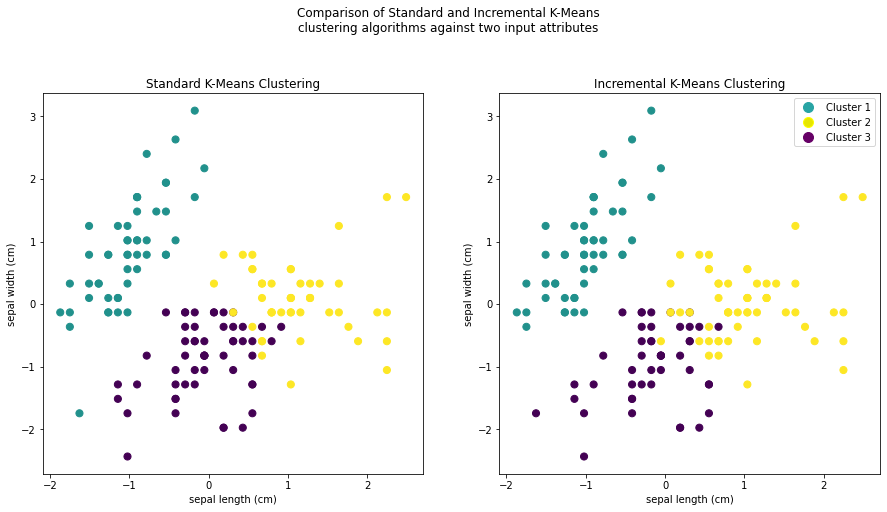

In [20]:
"""

Figure comparing KMeans clustering on two input attributes.

"""

from matplotlib.lines import Line2D

# Create figure and axes
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)


# Set title and labels for each graph
ax1.set_title('Standard K-Means Clustering')
ax1.set_xlabel(data.feature_names[0])
ax1.set_ylabel(data.feature_names[1])

ax2.set_title('Incremental K-Means Clustering')
ax2.set_xlabel(data.feature_names[0])
ax2.set_ylabel(data.feature_names[1])

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color = '#28a4a4', label='Cluster 1', markerfacecolor='#28a4a4', markersize=10, lw=0),
                   Line2D([0], [0], marker='o', color = '#ffff00', label='Cluster 2', markerfacecolor='#e6e600', markersize=10, lw=0),
                   Line2D([0], [0], marker='o', color = '#660066', label='Cluster 3', markerfacecolor='#660066', markersize=10, lw=0)]
# Draw legend
ax2.legend(handles=legend_elements, loc='upper right', fontsize="medium")

# Scatter input attributes, and colour points by cluster
ax1.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
ax2.scatter(x[:, 0], x[:, 1], c=y_kmeans_incr, s=50, cmap='viridis')

# Set main title
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle('Comparison of Standard and Incremental K-Means\nclustering algorithms against two input attributes', fontsize=12)

# Show the figure
plt.show()
